In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from scipy.optimize import minimize
from scipy.optimize import minimize
from scipy import stats

In [2]:
dat=pd.read_csv("Foreign_Exchange_Rates.csv")

In [3]:
dat.head(5)

,Unnamed: 0,Time Serie,AUSTRALIA - AUSTRALIAN DOLLAR/US$,EURO AREA - EURO/US$,NEW ZEALAND - NEW ZELAND DOLLAR/US$,UNITED KINGDOM - UNITED KINGDOM POUND/US$,BRAZIL - REAL/US$,CANADA - CANADIAN DOLLAR/US$,CHINA - YUAN/US$,HONG KONG - HONG KONG DOLLAR/US$,...,SINGAPORE - SINGAPORE DOLLAR/US$,DENMARK - DANISH KRONE/US$,JAPAN - YEN/US$,MALAYSIA - RINGGIT/US$,NORWAY - NORWEGIAN KRONE/US$,SWEDEN - KRONA/US$,SRI LANKA - SRI LANKAN RUPEE/US$,SWITZERLAND - FRANC/US$,TAIWAN - NEW TAIWAN DOLLAR/US$,THAILAND - BAHT/US$
0,0,2000-01-03,1.5172,0.9847,1.9033,0.6146,1.805,1.4465,8.2798,7.7765,...,1.6563,7.329,101.7,3.8,7.964,8.443,72.3,1.5808,31.38,36.97
1,1,2000-01-04,1.5239,0.97,1.9238,0.6109,1.8405,1.4518,8.2799,7.7775,...,1.6535,7.218,103.09,3.8,7.934,8.36,72.65,1.5565,30.6,37.13
2,2,2000-01-05,1.5267,0.9676,1.9339,0.6092,1.856,1.4518,8.2798,7.778,...,1.656,7.208,103.77,3.8,7.935,8.353,72.95,1.5526,30.8,37.1
3,3,2000-01-06,1.5291,0.9686,1.9436,0.607,1.84,1.4571,8.2797,7.7785,...,1.6655,7.2125,105.19,3.8,7.94,8.3675,72.95,1.554,31.75,37.62
4,4,2000-01-07,1.5272,0.9714,1.938,0.6104,1.831,1.4505,8.2794,7.7783,...,1.6625,7.2285,105.17,3.8,7.966,8.415,73.15,1.5623,30.85,37.3


In [4]:
ts1=pd.to_numeric(dat["AUSTRALIA - AUSTRALIAN DOLLAR/US$"],errors='coerce').dropna().reset_index()
ts1=ts1["AUSTRALIA - AUSTRALIAN DOLLAR/US$"]
ts2=pd.to_numeric(dat["EURO AREA - EURO/US$"],errors='coerce').dropna().reset_index()
ts2=ts2["EURO AREA - EURO/US$"]
ts3=pd.to_numeric(dat["JAPAN - YEN/US$"],errors='coerce').dropna().reset_index()
ts3=ts3["JAPAN - YEN/US$"]
ts4=pd.to_numeric(dat["UNITED KINGDOM - UNITED KINGDOM POUND/US$"],errors='coerce').dropna().reset_index()
ts4=ts4["UNITED KINGDOM - UNITED KINGDOM POUND/US$"]

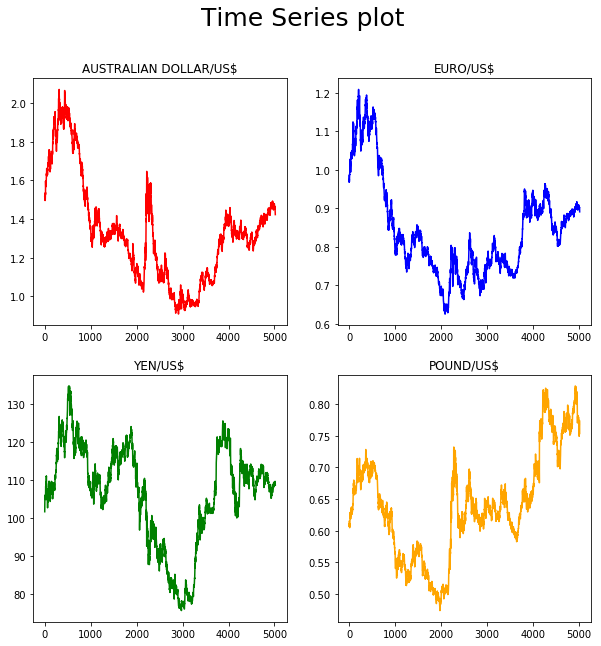

In [5]:
fig, axs = plt.subplots(2,2)
fig.set_figheight(10);
fig.set_figwidth(10);
axs[0,0].plot(ts1,color="red")
axs[0,1].plot(ts2,color="blue")
axs[1,0].plot(ts3,color="green")
axs[1,1].plot(ts4,color="orange")
axs[0,0].set_title("AUSTRALIAN DOLLAR/US$");
axs[0,1].set_title("EURO/US$");
axs[1,0].set_title("YEN/US$");
axs[1,1].set_title("POUND/US$");
fig.suptitle("Time Series plot",size=25);

# Auto Regressive Integrated Moving Average Model: ARIMA(p,d,q)  

## Test for Stationarity to determine order d

I am using ADF test for stationarity check here. The lag order (p) in the ADF test is given by the documentation of "tseries" package of R: $$p=trunc((length(x)-1)^{(1/3)})$$ where "trunc" is a function to make the float object into integer towards 0 and "x" is the time series.

In [6]:
def adf_test(data):
    k=int((len(data)-1)**(1/3))
    k=k+1
    y=np.zeros(len(data)-k)
    x=np.zeros([len(data)-k,k])
    for i in range(k,len(data)):
        y[i-k]=data[i]-data[i-1]
        x[i-k,0]=data[i-1]
        for j in range(1,k):
            x[i-k,j]=data[i-j]-data[i-j-1]
    trend=np.reshape(np.arange(k,len(data),1),(len(data)-k,1)) #Adding trend into the model
    x=np.hstack((trend,x))                                          # Addign trend as an explanatory variable
    x=np.hstack((np.ones([x.shape[0],1]),x))
    beta=np.matmul(np.linalg.inv(np.matmul(np.matrix.transpose(x),x)),np.matmul(np.matrix.transpose(x),y))
    res=y-np.matmul(x,beta)
    sd=np.dot(np.matrix.transpose(res),res)/(len(y)-len(beta))
    se=sd*np.linalg.inv(np.matmul(np.matrix.transpose(x),x))
    t=beta[2]/(se[2,2]**0.5)
    return t

### Augmented Dickey-Fuller (ADF) Test results

In [7]:
print("ADF test statistic for AUD/USD:",adf_test(ts1))
print("ADF test statistic for EURO/USD:",adf_test(ts2))
print("ADF test statistic for Yen/USD:",adf_test(ts3))
print("ADF test statistic for Pound/USD:",adf_test(ts4))

ADF test statistic for AUD/USD: -1.3064760652043317
ADF test statistic for EURO/USD: -1.477475047653281
ADF test statistic for Yen/USD: -1.7493074741721384
ADF test statistic for Pound/USD: -1.8808972121298713


For model with trend and constant mean, the critical value for the ADF test statistic is -3.41 at 5% level of significance. Our obtained test statistic for all the four time series are larger than the critical value. Therefore, we cannot reject the null hypothesis of unit root. 

#### Compare with python package

In [8]:
from statsmodels.tsa import stattools as tools

In [9]:
print("ADF test statistic for AUD/USD:",tools.adfuller(ts1,17,regression="ct", autolag=None)[0])
print("ADF test statistic for AUD/USD:",tools.adfuller(ts2,17,regression="ct", autolag=None)[0])
print("ADF test statistic for AUD/USD:",tools.adfuller(ts3,17,regression="ct", autolag=None)[0])
print("ADF test statistic for AUD/USD:",tools.adfuller(ts4,17,regression="ct", autolag=None)[0])

ADF test statistic for AUD/USD: -1.3064760652006442
ADF test statistic for AUD/USD: -1.4774750476556726
ADF test statistic for AUD/USD: -1.7493074741719994
ADF test statistic for AUD/USD: -1.8808972121254062


### ADF for First Order Difference

In [10]:
print("ADF test statistic for AUD/USD:",adf_test(np.diff(ts1)))
print("ADF test statistic for EURO/USD:",adf_test(np.diff(ts2)))
print("ADF test statistic for Yen/USD:",adf_test(np.diff(ts3)))
print("ADF test statistic for Pound/USD:",adf_test(np.diff(ts4)))

ADF test statistic for AUD/USD: -16.413937982596366
ADF test statistic for EURO/USD: -16.62152915262816
ADF test statistic for Yen/USD: -16.744007541867692
ADF test statistic for Pound/USD: -16.573536686910487


The test statistic value for the first order difference is significantly lower than the critical value. Therefore, we can conclude that the series is stationary at the first difference. 

### ACF to determine order q

<BarContainer object of 30 artists>

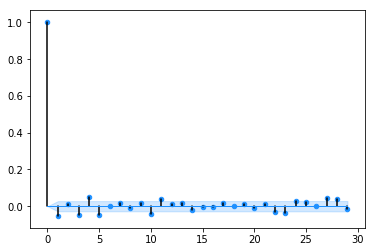

In [11]:
# def my_acf (data):    
#     resid=np.diff(ts1)
data=np.diff(ts1)
ACF=np.zeros(30)
ACF[0]=stats.pearsonr(data,data)[0]
for i in range(1,len(ACF)):
    lag=data[i:]
    new_dat=data[:len(lag)]
    ACF[i]=stats.pearsonr(new_dat,lag)[0]

# var_acf=1/(len(np.diff(ts1)));              ##this contant variance is used in R 

var_acf = np.ones(30) / len(data)
var_acf[0] = 0
var_acf[1] = 1. / len(data)
var_acf[2:] *= 1 + 2 * np.cumsum(ACF[1:-1]**2) # In python, Bartlett's formula is used

plt.bar(range(len(ACF)), ACF, width=0, ec="k", capstyle="round", linewidth=1.5);
plt.scatter(range(len(ACF)), ACF, color="dodgerblue", s=20)
plt.fill_between(range(len(ACF)), (1.96*var_acf**0.5), -(1.96*var_acf**0.5),color="dodgerblue", alpha=0.2)
plt.plot(range(len(ACF)),np.zeros(30),linestyle='solid',color="dodgerblue",linewidth=1);
plt.show()

#### Compare with python package 

In [12]:
from statsmodels.graphics.tsaplots import plot_acf as acf 

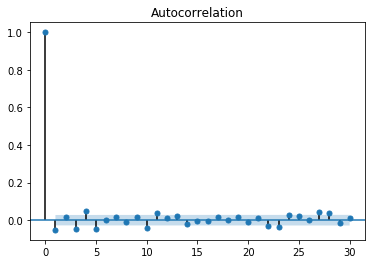

In [13]:
acf(np.diff(ts1),lags=30);

### PACF to determine order p

<BarContainer object of 25 artists>

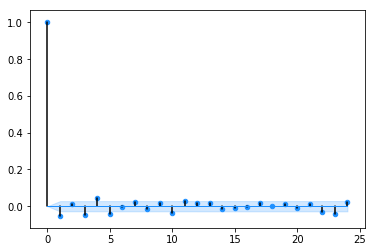

In [14]:
w=np.diff(ts1)
PACF=np.zeros(25)
PACF[0]=1
for k in range(1,len(PACF)):
    y=np.zeros(len(w)-k)
    x=np.zeros([len(w)-k,k])
    for i in range(len(w)-k):
        y[i]=w[i]
        for j in range(k):
            x[i,j]=w[i+j+1]
    theta=np.matmul(np.linalg.inv(np.matmul(np.matrix.transpose(x),x)),np.matmul(np.matrix.transpose(x),y))
    PACF[k]=theta[k-1]
    
var_pacf = np.ones(25) / len(data)
var_pacf[0] = 0
var_pacf[1] = 1. / len(data)
var_pacf[2:] *= 1 + 2 * np.cumsum(PACF[1:-1]**2) # In python, Bartlett's formula is used
    
plt.bar(range(len(PACF)), PACF, width=0, ec="k", capstyle="round", linewidth=1.5);
plt.scatter(range(len(PACF)), PACF, color="dodgerblue", s=20)
plt.fill_between(range(len(PACF)), (1.96*var_pacf**0.5), -(1.96*var_pacf**0.5),color="dodgerblue", alpha=0.2)
#plt.plot(range(len(PACF)),np.ones(25)*(1.96/(len(np.diff(ts1)))**0.5),linestyle='dashed',color="blue"); 
#plt.plot(range(len(PACF)),-np.ones(25)*(1.96/(len(np.diff(ts1)))**0.5),linestyle='dashed',color="blue");
plt.plot(range(len(PACF)),np.zeros(25),linestyle='solid',color="dodgerblue",linewidth=1);
plt.show()

#### Comapre with python package

In [15]:
from statsmodels.graphics.tsaplots import plot_pacf as pacf 

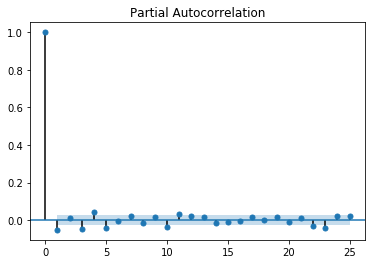

In [16]:
pacf(np.diff(ts1), lags=25);

## ARIMA (p,d,q) Model 

In [17]:
def ARIMA_css(par,p,d,q,data):
    
    
    for i in (range(d)):
        data=np.diff(data)
    
    phi=np.array(par[1:p+1])
    theta=np.array(par[p+1:])
    res=np.zeros(len(data))
    
    z=np.zeros([len(data)-max(p,q),q])
    y=np.zeros(len(data)-max(p,q))
    x=np.zeros((len(data)-max(p,q),p))

    for i in range(max(p,q),len(data)):
        y[i-max(p,q)]=data[i]-par[0]
        for j in range(p):
            x[i-max(p,q),j]=data[i-j-1]-par[0]
        res[i]=y[i-max(p,q)]-np.dot(x[i-max(p,q),:],phi)-np.dot(res[i-q:i],theta)

    for i in range(max(p,q),len(data)):
            z[i-max(p,q),:]=res[i-q:i]
    
    obj_fun=np.dot(y-np.dot(x,phi)-np.dot(z,theta),y-np.dot(x,phi)-np.dot(z,theta))
    
    
    return obj_fun

In [18]:
minimize(ARIMA_css,[0,0,0,0,0],args=(2,1,2,ts1))

      fun: 0.6052111677004296
 hess_inv: array([[ 9.96805501e-05, -2.14665385e-04, -1.57255329e-04,
         1.41928260e-04,  2.04638898e-04],
       [-2.14665385e-04,  2.45249780e+02,  1.55900110e+02,
        -1.41245415e+02, -2.43691017e+02],
       [-1.57255329e-04,  1.55900110e+02,  1.29861666e+02,
        -1.20862980e+02, -1.54190762e+02],
       [ 1.41928260e-04, -1.41245415e+02, -1.20862980e+02,
         1.13391714e+02,  1.39685638e+02],
       [ 2.04638898e-04, -2.43691017e+02, -1.54190762e+02,
         1.39685638e+02,  2.42809233e+02]])
      jac: array([-1.63912773e-07, -4.69386578e-07, -1.19209290e-07, -1.34110451e-07,
       -5.73694706e-07])
  message: 'Optimization terminated successfully.'
     nfev: 259
      nit: 31
     njev: 37
   status: 0
  success: True
        x: array([-2.11130933e-05, -1.03845625e-01,  4.68228441e-01, -4.51079714e-01,
        4.57480098e-02])

#### Compare with python package

In [19]:
from statsmodels.tsa import arima_process
from statsmodels.tsa.arima_model import ARIMA

In [20]:
model=ARIMA(ts1,(2,1,2))
model_fit=model.fit(method="css")
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      ARIMA Model Results                                      
===============================================================================================
Dep. Variable:     D.AUSTRALIA - AUSTRALIAN DOLLAR/US$   No. Observations:                 5018
Model:                                  ARIMA(2, 1, 2)   Log Likelihood               15511.200
Method:                                            css   S.D. of innovations              0.011
Date:                                 Tue, 07 Apr 2020   AIC                         -31010.399
Time:                                         03:02:44   BIC                         -30971.277
Sample:                                              3   HQIC                        -30996.690
                                                                                               
=============================================================================================================
                                                coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
const                                     -2.111e-05      0.000     -0.145      0.884      -0.000       0.000
ar.L1.D.AUSTRALIA - AUSTRALIAN DOLLAR/US$    -0.1039      0.265     -0.392      0.695      -0.623       0.415
ar.L2.D.AUSTRALIA - AUSTRALIAN DOLLAR/US$     0.4682      0.189      2.481      0.013       0.098       0.838
ma.L1.D.AUSTRALIA - AUSTRALIAN DOLLAR/US$     0.0458      0.264      0.173      0.862      -0.472       0.563
ma.L2.D.AUSTRALIA - AUSTRALIAN DOLLAR/US$    -0.4511      0.176     -2.565      0.010      -0.796      -0.106
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.3547           +0.0000j            1.3547            0.5000
AR.2            1.5766           +0.0000j            1.5766            0.0000
MA.1           -1.4391           +0.0000j            1.4391            0.5000
MA.2            1.5406           +0.0000j            1.5406            0.0000
-----------------------------------------------------------------------------
"""

In [949]:
def predict(data,par,p,d,q,size):
    
    dat=data
    
    for i in (range(d)):
        data=np.diff(data)
    
    data=data[:-size]
    

    mod=minimize(ARIMA_css,par,args=(p,d,q,data))
    est=mod.x
    msg=mod.message

    phi=est[1:p+1]
    theta=est[p+1:]

    res=np.zeros(len(dat))

    for i in range(max(p,q),len(data)):
        res[i]=data[i]-est[0]-np.dot(data[i-p:i]-est[0],phi)-np.dot(res[i-q:i],theta)


    tr_phi=np.zeros(p+1)
    tr_phi[0]=1+phi[0]
    tr_phi[-1]=phi[-1]
    tr_phi[1:p]=np.diff(phi)


    n=len(dat)-size
    y=np.zeros(size)
    forecast=np.zeros(size)
    #x=np.zeros((size,p+1))
    #z=np.zeros((size,q))
    
    for i in (range(size)):
        y[i]=dat[n+i]
        for j in (range(p+1)):
            x[i,j]=dat[n+i-j-1]
        forecast[i]=est[0]+np.dot(x[i]-est[0],tr_phi)
#         res[n+i]=y[i]-est[0]-np.dot(x[i]-est[0],tr_phi)-np.dot(res[n+i-q:n+i],theta)

    forecast[0]=forecast[0]+np.dot(res[n-q:n],theta)
    
#     for i in range(size):
#         z[i,:]=res[n+i-q:n+i]

#         forecast=est[0]+np.dot(x,tr_phi)+np.dot(z,theta)   
    
    mse=(y-forecast)@(y-forecast)/len(y)
    
    return {"test":y,"pred":forecast,"mse":mse, "par": est, "message": msg}

In [953]:
res11=predict(data=ts1,par=[0,0,0],p=1,d=1,q=1,size=100)
# res10=predict(data=ts1,par=[0,0],p=1,d=1,q=0,size=100)
# res01=predict(data=ts1,par=[0,0],p=0,d=1,q=1,size=100)

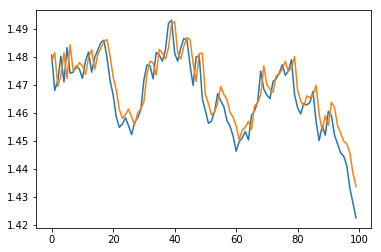

In [960]:
plt.plot(res11["test"])
plt.plot(res11["pred"]+0.1555)

In [394]:
def sig_cons(par):
    return par[-1]
def beta_cons(par):
    return 1-par[0]
def beta2_cons(par):
    return 1-par[0]**2

cons = ({'type': 'ineq', 'fun': sig_cons},
        {'type': 'ineq', 'fun': beta_cons},
        {'type': 'ineq', 'fun': beta2_cons})

In [395]:
minimize(AR1_SS,np.array([0.5,0.01]),args=(np.diff(ts1)),constraints=cons, method="SLSQP")

     fun: nan
     jac: array([nan, nan])
 message: 'Iteration limit exceeded'
    nfev: 1002
     nit: 101
    njev: 99
  status: 9
 success: False
       x: array([nan, nan])

In [255]:
def log_lik(par, data, k):
    beta=par[:k+1]
    sig=par[-1]
    phi=0
    for i in range(1,len(beta)):
        phi=phi+beta[i]
    init_mu=beta[0]/(1-phi)
    phi2=0
    for i in range(1,len(beta)):
        phi2=phi2+beta[i]**2
    init_sig=sig/(1-phi2)
    init_loglik=-0.5*np.log(init_sig)-0.5*(1/init_sig)*(data[0]-init_mu)**2
    y=np.zeros(len(data)-k)
    x=np.zeros([len(data)-k,k])
    for i in range(k,len(data)):
        y[i-k]=data[i]
        x[i-k,0]=data[i-1]
        for j in range(1,k):
            x[i-k,j]=data[i-j]
    x=np.hstack((np.ones([x.shape[0],1]),x))
    exact_loglik=init_loglik
    for i in range(1,len(y)):
        exact_loglik=exact_loglik-0.5*np.log(sig)-0.5*(1/sig)*(y[i]-np.matmul(x[i,],beta))**2
    return -exact_loglik

In [256]:
def sig_cons(par):
    return par[len(par)-1]
def beta_cons(par):
    return 1-np.sum(par[:-1])
def beta2_cons(par):
    return 1-np.sum(par[:-1]**2)

In [257]:
cons = ({'type': 'ineq', 'fun': sig_cons},
        {'type': 'ineq', 'fun': beta_cons},
        {'type': 'ineq', 'fun': beta2_cons})

In [261]:
mod1=minimize(log_lik,np.array([0.1,0.1,0.5]),args=(np.diff(ts1),1),constraints=cons,method='SLSQP')
aic1=2*3+2*mod1.fun
mod1

     fun: -20118.213501329283
     jac: array([-1.43457031e+00, -1.22070312e-02,  2.02194824e+02])
 message: 'Optimization terminated successfully.'
    nfev: 238
     nit: 40
    njev: 40
  status: 0
 success: True
       x: array([-2.05376346e-05, -5.17930978e-02,  1.20957692e-04])

In [14]:
mod2=minimize(log_lik,np.array([0.1,0.1,0.1,0.5]),args=(np.diff(ts1),2),constraints=cons,method='SLSQP')
aic2=2*3+2*mod2.fun
mod2

     fun: -20113.731168966664
     jac: array([-0.26367188, -0.01025391, -0.01025391, -3.24023438])
 message: 'Optimization terminated successfully.'
    nfev: 208
     nit: 30
    njev: 30
  status: 0
 success: True
       x: array([-2.10194798e-05, -2.59031290e-02, -2.59031290e-02,  1.20979309e-04])

In [195]:
mod3=minimize(log_lik,np.array([-0.1,0.2,0.1,0.1,0.5]),args=(np.diff(ts1),3),constraints=cons,method='SLSQP')
aic3=2*3+2*mod3.fun
mod3

     fun: -20109.576919012918
     jac: array([-8.54003906e-01,  2.09960938e-02,  2.09960938e-02,  2.19726562e-02,
       -6.51350098e+01])
 message: 'Optimization terminated successfully.'
    nfev: 223
     nit: 28
    njev: 26
  status: 0
 success: True
       x: array([-2.04378744e-05, -2.55014858e-02, -2.56864964e-02,  1.16986621e-02,
        1.20985910e-04])

In [16]:
mod4=minimize(log_lik,np.array([-0.1,-0.1,-0.1,0.1,0.1,0.5]),args=(np.diff(ts1),4),constraints=cons,method='SLSQP')
aic4=2*3+2*mod4.fun
mod4

     fun: -20110.292040937893
     jac: array([-1.75512695e+00,  6.32324219e-02,  6.34765625e-02, -2.63671875e-02,
        3.34472656e-02,  8.72734619e+02])
 message: 'Optimization terminated successfully.'
    nfev: 454
     nit: 49
    njev: 49
  status: 0
 success: True
       x: array([-2.07089080e-05, -2.53866306e-02, -2.52729417e-02,  9.36827961e-03,
       -4.54510246e-02,  1.20763495e-04])

In [17]:
mod5=minimize(log_lik,np.array([-0.1,-0.1,0.1,0.1,0.1,0.1,0.5]),args=(np.diff(ts1),5),constraints=cons,method='SLSQP')
aic5=2*3+2*mod5.fun
mod5

     fun: -20111.174969007323
     jac: array([-2.84912109e-01,  1.04980469e-02,  1.07421875e-02, -1.14746094e-02,
        6.10351562e-03, -4.63867188e-03,  1.72678223e+01])
 message: 'Optimization terminated successfully.'
    nfev: 341
     nit: 35
    njev: 34
  status: 0
 success: True
       x: array([-1.91269539e-05, -2.44836224e-02, -2.41036516e-02,  8.93431698e-03,
       -4.30963949e-02,  4.61717207e-02,  1.20522917e-04])

In [185]:
def predict(data,k,test):
    y=np.zeros(len(data)-k)
    x=np.zeros([len(data)-k,k])
    for i in range(k,len(data)):
        y[i-k]=data[i]
        for j in range(k):
            x[i-k,j]=data[i-j-1]
    x=np.hstack((np.ones([x.shape[0],1]),x))
    beta=np.matmul(np.linalg.inv(np.matmul(np.matrix.transpose(x),x)),np.matmul(np.matrix.transpose(x),y))
    y=np.zeros(test)
    x=np.zeros([test,k])
    for i in range(test):
        y[i]=data[test+i]
        for j in range(k):
            x[i,j]=data[test+i-1-j]
    x=np.hstack((np.ones([x.shape[0],1]),x))
    forecast=x@beta
    mse=(y-forecast)@(y-forecast)/len(y)
    return {"test":y,"pred":forecast,"mse":mse,"par":beta}

In [189]:
rs3=predict(np.diff(ts1),3,100)
rs3["par"]

array([-2.27765491e-05, -5.06731615e-02,  9.35335332e-03, -4.54941234e-02])

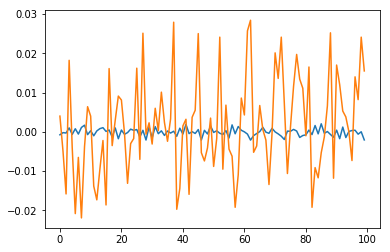

In [187]:
rs4=predict(np.diff(ts1),4,100)
plt.plot(rs4["pred"])
plt.plot(rs4["test"])

In [181]:
plt.plot(rs4["test"])
plt.plot(rs4["pred"])
plt.show()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [153]:
k=2
data=np.diff(ts1)
y=np.zeros(len(data)-k)
x=np.zeros([len(data)-k,k])
for i in range(k,len(data)):
    y[i-k]=data[i]-data[i-1]
    x[i-k,0]=data[i-1]
    for j in range(1,k):
        x[i-k,j]=data[i-j]-data[i-j-1]
x=np.hstack((np.ones([x.shape[0],1]),x))
beta=np.matmul(np.linalg.inv(np.matmul(np.matrix.transpose(x),x)),np.matmul(np.matrix.transpose(x),y))
beta

array([-2.15578448e-05, -1.03947530e+00, -1.17144008e-02])

In [195]:
aic1=2*1-2*mod1.fun
aic2=2*2-2*mod2.fun
aic3=2*3-2*mod3.fun
aic4=2*4-2*mod4.fun
aic5=2*5-2*mod5.fun
aic1
aic2
aic3
aic4
aic5

40238.427001034885

40231.46233793333

40225.153843607404

40228.584081875786

40232.349938014646

#### Serial correlation check

In [19]:
def res(data,beta):
    k=len(beta)-1
    y=np.zeros(len(data)-k)
    x=np.zeros([len(data)-k,k])
    for i in range(len(data)-k):
        y[i]=data[i]
        for j in range(k):
            x[i,j]=data[i+j+1]
    x=np.hstack((np.ones([x.shape[0],1]),x))
    ehat=y-np.matmul(x,beta)
    return ehat
res(np.diff(ts1),mod1.x)

array([ 0.00686374,  0.00294354,  0.00232096, ..., -0.00135613,
       -0.00379471, -0.00825486])

In [33]:
k=3
w=res(np.diff(ts1),mod1.x)
y=np.zeros(len(w)-k)
x=np.zeros([len(w)-k,k])
for i in range(len(w)-k):
    y[i]=w[i]
    for j in range(k):
        x[i,j]=w[i+j+1]
theta=np.matmul(np.linalg.inv(np.matmul(np.matrix.transpose(x),x)),np.matmul(np.matrix.transpose(x),y))
theta
w_res=y-np.matmul(x,theta)
res_sd=np.matmul(np.ones(len(w_res)),w_res*w_res)/(len(w_res)-k)
theta_sd=res_sd*np.linalg.inv(np.matmul(np.matrix.transpose(x),x))
theta_sd

array([ 0.00085173,  0.00909894, -0.04362031])

array([[ 1.99235830e-04, -8.58478221e-08, -1.80699192e-06],
       [-8.58478221e-08,  1.99217600e-04, -9.39533699e-08],
       [-1.80699192e-06, -9.39533699e-08,  1.99213348e-04]])

In [34]:
R=np.identity(k)
r=np.zeros(k)
w1=np.matrix.transpose((np.matmul(R,theta)-r))
w2=np.linalg.inv(np.matmul(np.matmul(R,theta_sd),np.matrix.transpose(R)))
w3=np.matmul(R,theta)-r
wald=np.matmul(np.matmul(w1,w2),w3)
wald

9.965989471173836

In [35]:
1-stats.chi2.cdf(wald,k)

0.018857460788552327

#### ACF and PACF

<BarContainer object of 30 artists>

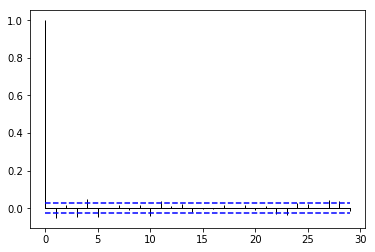

In [23]:
resid=np.diff(ts1)
ACF=np.zeros(30)
ACF[0]=stats.pearsonr(resid,resid)[0]
for i in range(1,len(ACF)):
    lag=resid[i:]
    new_res=resid[:len(lag)]
    ACF[i]=stats.pearsonr(new_res,lag)[0]

plt.bar(range(len(ACF)), ACF, width=0, ec="k");
plt.plot(range(len(ACF)),np.ones(30)*(1.96/(len(np.diff(ts1)))**0.5),linestyle='dashed',color="blue");
plt.plot(range(len(ACF)),-np.ones(30)*(1.96/(len(np.diff(ts1)))**0.5),linestyle='dashed',color="blue");
plt.plot(range(len(ACF)),np.zeros(30),linestyle='solid',color="black",linewidth=1);
plt.show()

<BarContainer object of 25 artists>

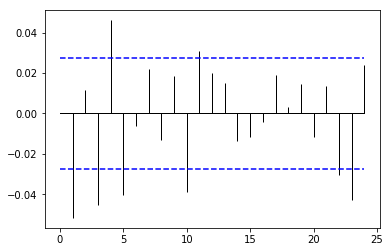

In [24]:
w=np.diff(ts1)
PACF=np.zeros(25)
for k in range(1,len(PACF)):
    y=np.zeros(len(w)-k)
    x=np.zeros([len(w)-k,k])
    for i in range(len(w)-k):
        y[i]=w[i]
        for j in range(k):
            x[i,j]=w[i+j+1]
    theta=np.matmul(np.linalg.inv(np.matmul(np.matrix.transpose(x),x)),np.matmul(np.matrix.transpose(x),y))
    PACF[k]=theta[k-1]
plt.bar(range(len(PACF)), PACF, width=0, ec="k");
plt.plot(range(len(PACF)),np.ones(25)*(1.96/(len(np.diff(ts1)))**0.5),linestyle='dashed',color="blue");
plt.plot(range(len(PACF)),-np.ones(25)*(1.96/(len(np.diff(ts1)))**0.5),linestyle='dashed',color="blue");
plt.plot(range(len(PACF)),np.zeros(25),linestyle='solid',color="black",linewidth=1);
plt.show()

### MA(q=2) model

In [135]:
def MA(par):
    beta=par[:-1]
    sig=par[len(par)-1]
    data=np.diff(ts1)
    q=2
    rho1=ACF[1]
    rho2=ACF[2]
    rat=rho1/rho2
    #theta2=(-rat+(rat**2-4*(rho1*rat+rho1-rat)*rho1))/(2*((rho1*rat+rho1-rat)))
    theta2=-0.25 # Here, we are just taking a value for theta: The recommeneded initial value of theta can be 
    theta1=0.50  # found in Box Jenkins book
    et=np.zeros(len(data))
    for i in range(q+1,len(data)):
        et[i]=data[i]+theta1*et[i-1]+theta2*et[i-2]
    y=np.zeros(len(data)-q)
    x=np.zeros([len(data)-q,q])
    for i in range(q+1,len(data)-q):
        y[i]=data[i]
        for j in range(q):
            x[i,j]=et[i+j+1]
    tot_loglik=0
    for i in range(1,len(y)):
        tot_loglik=tot_loglik-0.5*np.log(sig)-0.5*(1/sig)*(y[i]-np.matmul(x[i,],beta))**2
    return -tot_loglik

In [136]:
def sig_cons(par):
    return par[len(par)-1]

In [137]:
cons = ({'type': 'ineq', 'fun': sig_cons})

In [138]:
minimize(MA,np.array([0.2,0.2,0.5]),constraints=cons,method='SLSQP')

C:\Users\Shakil\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in log


     fun: -20637.89641017618
     jac: array([1.07421875e-02, 8.78906250e-03, 3.66255615e+02])
 message: 'Optimization terminated successfully.'
    nfev: 117
     nit: 19
    njev: 19
  status: 0
 success: True
       x: array([ 4.26306665e-01, -1.61715316e-01,  9.80013933e-05])

### ARIMA (p,d,q) model

In [167]:
def ARIMA(par,p,d,q,data):
    
    for i in (range(d)):
        data=np.diff(data)
    
    y=np.zeros(len(data)-np.maximum(p,q))
    x=np.zeros([len(data)-np.maximum(p,q),p])
    
    for i in range(len(data)-np.maximum(p,q)):
        y[i]=data[i]
        for j in range(p):
            x[i,j]=data[i+j+1]
    x=np.hstack((np.ones([x.shape[0],1]),x))
    theta=np.matmul(np.linalg.inv(np.matmul(np.matrix.transpose(x),x)),np.matmul(np.matrix.transpose(x),y))
    res=y-np.matmul(x,theta)
    z=np.zeros([len(data)-np.maximum(p,q),q])
    for i in range(len(data)-np.maximum(p,q)):
        for j in range(q):
            z[i,j]=res[i+j]
    x=np.hstack((x,z))
    
    beta=par[:-1]
    sig=par[len(par)-1]
    phi=0
    for i in range(p):
        phi=phi+beta[i]
    init_mu=beta[0]/(1-phi)
    phi2=0
    for i in range(p):
        phi2=phi2+beta[i]**2
    init_sig=sig/(1-phi2)
    init_loglik=-0.5*np.log(init_sig)-0.5*(1/init_sig)*(data[0]-init_mu)**2
    exact_loglik=init_loglik
    for i in range(1,len(y)):
        exact_loglik=exact_loglik-0.5*np.log(sig)-0.5*(1/sig)*(y[i]-np.matmul(x[i,],beta))**2
    return -exact_loglik

In [168]:
q=1
def sig_cons(par):
    return par[len(par)-1]
def beta_cons(par):
    return 1-np.sum(par[:-1-q])
def beta2_cons(par):
    return 1-np.sum(par[:-1-q]**2)

In [169]:
cons = ({'type': 'ineq', 'fun': sig_cons},
        {'type': 'ineq', 'fun': beta_cons},
        {'type': 'ineq', 'fun': beta2_cons})

In [196]:
minimize(ARIMA,np.array([-0.01,-0.01,0.001,0.5]),constraints=cons,args=(1,1,1,ts1),method='SLSQP')

C:\Users\Shakil\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in log
C:\Users\Shakil\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in log
C:\Users\Shakil\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in log
C:\Users\Shakil\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\Shakil\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Shakil\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log
C:\Users\Shakil\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in double_scalars


     fun: -43908.83534352946
     jac: array([3.02442506e+06, 7.26785586e+04, 7.30264404e+03, 5.29257630e+10])
 message: 'Optimization terminated successfully.'
    nfev: 682
     nit: 94
    njev: 93
  status: 0
 success: True
       x: array([-1.26100400e-05, -5.07904778e-02,  1.00009799e+00,  8.13407269e-09])

In [179]:
def log_lik(par):
    data=np.diff(ts2)
    beta=par[:-1]
    sig=par[len(par)-1]
    phi=0
    for i in range(1,len(beta)):
        phi=phi+beta[i]
    init_mu=beta[0]/(1-phi)
    phi2=0
    for i in range(1,len(beta)):
        phi2=phi2+beta[i]**2
    init_sig=sig/(1-phi2)
    init_loglik=-0.5*np.log(init_sig)-0.5*(1/init_sig)*(data[0]-init_mu)**2
    k=len(beta)-1
    y=np.zeros(len(data)-k)
    x=np.zeros([len(data)-k,k])
    for i in range(len(data)-k):
        y[i]=data[i]
        for j in range(k):
            x[i,j]=data[i+j+1]
    x=np.hstack((np.ones([x.shape[0],1]),x))
    exact_loglik=init_loglik
    for i in range(1,len(y)):
        exact_loglik=exact_loglik-0.5*np.log(sig)-0.5*(1/sig)*(y[i]-np.matmul(x[i,],beta))**2
    return -exact_loglik

In [180]:
def sig_cons(par):
    return par[len(par)-1]
def beta_cons(par):
    return 1-np.sum(par[:-1])
def beta2_cons(par):
    return 1-np.sum(par[:-1]**2)

In [181]:
cons = ({'type': 'ineq', 'fun': sig_cons},
        {'type': 'ineq', 'fun': beta_cons},
        {'type': 'ineq', 'fun': beta2_cons})

In [190]:
mod1=minimize(log_lik,np.array([-0.1,0.2,1]),constraints=cons,method='SLSQP')
aic1=2*3+2*mod1.fun
mod1

     fun: -23870.507677534482
     jac: array([-2.07058105e+01, -5.09765625e-01,  1.21943728e+04])
 message: 'Optimization terminated successfully.'
    nfev: 362
     nit: 57
    njev: 57
  status: 0
 success: True
       x: array([-1.85649021e-05,  1.05694462e-02,  2.70995781e-05])

In [194]:
mod2=minimize(log_lik,np.array([-0.1,0.2,-0.1,1]),constraints=cons,method='SLSQP')
aic2=2*3+2*mod2.fun
mod2

     fun: -23866.102090142773
     jac: array([ 4.28515625e+00,  7.32421875e-03, -1.46484375e-02, -4.23796875e+02])
 message: 'Optimization terminated successfully.'
    nfev: 303
     nit: 43
    njev: 42
  status: 0
 success: True
       x: array([-1.79554487e-05,  1.08248532e-02, -1.60284330e-02,  2.70920757e-05])

In [196]:
mod3=minimize(log_lik,np.array([-0.1,0.2,-0.1,-0.1,1]),constraints=cons,method='SLSQP')
aic3=2*3+2*mod3.fun
mod3

     fun: -23861.472885376283
     jac: array([ 7.64355469e+00,  1.78222656e-02, -9.66796875e-02,  1.24511719e-02,
        3.73666748e+02])
 message: 'Optimization terminated successfully.'
    nfev: 332
     nit: 41
    njev: 40
  status: 0
 success: True
       x: array([-1.68259752e-05,  1.06392432e-02, -1.60510389e-02, -2.59609276e-03,
        2.70909172e-05])

In [199]:
mod4=minimize(log_lik,np.array([-0.1,0.2,-0.1,-0.1,0.2,1]),constraints=cons,method='SLSQP')
aic4=2*3+2*mod4.fun
mod4

     fun: -23860.141712880926
     jac: array([-1.96757812e+01, -1.42089844e-01,  2.90283203e-01, -3.32031250e-02,
       -8.86230469e-02,  1.81501875e+04])
 message: 'Optimization terminated successfully.'
    nfev: 357
     nit: 38
    njev: 37
  status: 0
 success: True
       x: array([-1.61242581e-05,  1.06434866e-02, -1.53793137e-02, -3.03735482e-03,
        3.93954323e-02,  2.70590879e-05])

In [201]:
mod5=minimize(log_lik,np.array([-0.1,0.2,-0.1,-0.1,0.2,0.2,1]),constraints=cons,method='SLSQP')
aic5=2*3+2*mod5.fun
mod5

     fun: -23858.02409865041
     jac: array([-1.33544922e+00,  1.24511719e-02,  2.63671875e-02,  5.85937500e-03,
       -1.46484375e-03,  1.07910156e-01,  6.79401123e+02])
 message: 'Optimization terminated successfully.'
    nfev: 537
     nit: 53
    njev: 52
  status: 0
 success: True
       x: array([-1.65666376e-05,  1.20715102e-02, -1.55126525e-02, -3.55422053e-03,
        3.98064304e-02, -3.53919647e-02,  2.70254757e-05])

In [202]:
aic1
aic2
aic3
aic4
aic5

-47735.015355068965

-47726.204180285546

-47716.945770752565

-47714.28342576185

-47710.04819730082

In [41]:
x=np.array([1,2,3,4])
x[2:-1]

array([3])

In [153]:
def kalman_arima(par,p,d,q,data):
    
    if d>0:
        mu=0
        phi=np.array(par[:p])
        theta=np.array(par[p:p+q])

    else:
        mu=np.array(par[0])
        phi=np.array(par[1:p+1])
        theta=np.array(par[p+1:-1])
        
    
    
    for i in range(d):
        data=np.diff(data)
        
    r=np.maximum(p,q+1)
    
    zi=np.zeros(r).reshape((r,1))
    
    H=np.hstack((1,theta)).reshape((q+1,1))
    
    P11=sig2/(1-np.sum(phi**2))
    P12=np.sum(phi)*sig2/(1-np.sum(phi**2))
    P21=np.sum(phi)*sig2/(1-np.sum(phi**2))
    P22=sig2/(1-np.sum(phi**2))
    
    P=np.array((P11,P12,P21,P22)).reshape((2,2))
    
    Q=np.hstack((sig2,np.zeros(r**2-1))).reshape((r,r))
    
    if r==p:
        
        F=np.vstack((phi,np.hstack((np.identity(r-1),np.zeros(r-1).reshape(r-1,1)))))
    
    else:
        F=np.hstack((phi,np.zeros(r-p)))
        F=np.vstack((F,np.hstack((np.identity(r-1),np.zeros(r-1).reshape(r-1,1)))))
    
    
    
    for i in range(len(data)):
        
        y=mu+H.T@zi
        e=data[i]-y
        
        dist_mu=mu+H.T@zi
        dist_sig=H.T@P@H

        log_lik=0
        log_lik=log_lik-np.log(dist_sig**0.5)-0.5*(1/(dist_sig))*(data[i]-dist_mu)
        
        zi=F@zi+F@P@H@np.linalg.inv(H.T@P@H)*e
        P=F@(P-P@H@np.linalg.inv(H.T@P@H)@H.T@P)@F.T+Q
    
    return -log_lik

In [154]:
p=1
q=1
def sig_cons(par):
    return par[-1]
def beta_cons(par):
    return 1-np.sum(par[:p])
def theta_cons(par):
    return 1-np.sum(par[p:p+q])
# def beta_cons(par):
#     return 1-np.sum(par[:p])
# def theta_cons(par):
#     return 1-np.sum(par[p:-1])
# def beta2_cons(par):
#     return 1-np.sum(par[:-1]**2)

cons = ({'type': 'ineq', 'fun': sig_cons})

In [162]:
minimize(kalman_arima,np.array([-0.2,-0.1,-0.2,0.1]),args=(1,1,1,ts1[:100]),constraints=cons, method="SLSQP")

     fun: 0.09697149109749748
     jac: array([0.44586751, 3.38153334, 0.        , 0.        ])
 message: 'Optimization terminated successfully.'
    nfev: 270
     nit: 31
    njev: 31
  status: 0
 success: True
       x: array([-2.85042846e+03,  1.83629258e+00, -2.00000000e-01,  1.00000000e-01])

In [149]:
from statsmodels.tsa import arima_process

In [72]:
ts=arima_process.arma_generate_sample(ar=np.r_[1,0.5],ma=np.r_[1,0.5],nsample=100)

In [139]:
par=[0.5,0.5,1]
p=1
q=1
d=1
mu=0
phi=np.array(par[:p])
theta=np.array(par[p:p+q])
H=np.hstack((1,theta)).reshape((q+1,1))
data=ts

r=np.maximum(p,q+1)

zi=np.zeros(r).reshape((r,1))

H=np.hstack((1,theta)).reshape((q+1,1))

P11=sig2/(1-np.sum(phi**2))
P12=np.sum(phi)*sig2/(1-np.sum(phi**2))
P21=np.sum(phi)*sig2/(1-np.sum(phi**2))
P22=sig2/(1-np.sum(phi**2))

P=np.array((P11,P12,P21,P22)).reshape((2,2))

Q=np.hstack((sig2,np.zeros(r**2-1))).reshape((r,r))

if r==p:

    F=np.vstack((phi,np.hstack((np.identity(r-1),np.zeros(r-1).reshape(r-1,1)))))

else:
    F=np.hstack((phi,np.zeros(r-p)))
    F=np.vstack((F,np.hstack((np.identity(r-1),np.zeros(r-1).reshape(r-1,1)))))



for i in range(len(data)):

    y=mu+H.T@zi
    e=data[i]-y

    dist_mu=mu+H.T@zi
    dist_sig=H.T@P@H

    log_lik=0
    log_lik=log_lik-np.log(dist_sig**0.5)-0.5*(1/(dist_sig))*(data[i]-dist_mu)

    zi=F@zi+F@P@H@np.linalg.inv(H.T@P@H)*e
    P=F@(P-P@H@np.linalg.inv(H.T@P@H)@H.T@P)@F.T+Q

In [140]:
log_lik

array([[-0.27233267]])

In [131]:
x=[5,2,3]
phi=x[1:1+1]
H=np.hstack((1,phi)).reshape((2,1))

In [970]:
x=[1,2,3]
a=[0.3]
np.array(x[2:3])*a

array([0.9])

In [968]:
x[2:3]

[3]